<a href="https://colab.research.google.com/github/Eatosin/Spectre-Deepfake-Detection/blob/main/Project_spectre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Install Audio Physics Libraries
!pip install librosa matplotlib numpy soundfile torch

# 2. Import them
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import torch
import os

print("✅ Physics Lab Environment Ready.")

✅ Physics Lab Environment Ready.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import librosa
import soundfile as sf
import os

print("🏭 Generating Synthetic Dataset...")
os.makedirs("dataset/real", exist_ok=True)
os.makedirs("dataset/fake", exist_ok=True)

def gen_wave(filename, is_fake=True):
    sr = 22050
    duration = 2
    t = np.linspace(0, duration, int(sr * duration))

    if is_fake:
        audio = 0.5 * np.sin(2 * np.pi * 440 * t) + 0.3 * np.sin(2 * np.pi * 880 * t)
    else:
        base = 0.5 * np.sin(2 * np.pi * 440 * t)
        jitter = 0.1 * np.random.normal(0, 1, len(t))
        breath = 0.05 * np.random.randn(len(t))
        audio = base + jitter + breath

    sf.write(filename, audio, sr)

for i in range(50):
    gen_wave(f"dataset/fake/fake_{i}.wav", is_fake=True)
    gen_wave(f"dataset/real/real_{i}.wav", is_fake=False)

print("✅ Dataset Created.")

class AudioDataset(Dataset):
    def __init__(self, file_list, labels):
        self.file_list = file_list
        self.labels = labels

    def __len__(self): return len(self.file_list)

    def __getitem__(self, idx):
        y, sr = librosa.load(self.file_list[idx], duration=2.0)
        melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
        melspec_db = librosa.power_to_db(melspec, ref=np.max)
        melspec_norm = (melspec_db - melspec_db.min()) / (melspec_db.max() - melspec_db.min())

        if melspec_norm.shape[1] > 80:
            melspec_norm = melspec_norm[:, :80]
        else:
            pad_width = 80 - melspec_norm.shape[1]
            melspec_norm = np.pad(melspec_norm, ((0,0), (0, pad_width)))

        return torch.tensor(melspec_norm, dtype=torch.float32).unsqueeze(0), torch.tensor(self.labels[idx], dtype=torch.long)

real_files = [f"dataset/real/{f}" for f in os.listdir("dataset/real")]
fake_files = [f"dataset/fake/{f}" for f in os.listdir("dataset/fake")]
all_files = real_files + fake_files
all_labels = [0]*len(fake_files) + [1]*len(real_files)

train_loader = DataLoader(AudioDataset(all_files, all_labels), batch_size=10, shuffle=True)
print("✅ Data Loaded.")

🏭 Generating Synthetic Dataset...
✅ Dataset Created.
✅ Data Loaded.


In [ ]:
# --- 3. THE BRAIN: SpectreNet (CNN) ---
class SpectreNet(nn.Module):
    def __init__(self):
        super(SpectreNet, self).__init__()
        # Layer 1: The Eye (Finds Edges)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Layer 2: The Texture Scanner (Finds Artificial smoothness)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        # Layer 3: The Decision Maker
        # (32 channels * 16 height * 20 width) comes from the math of pooling
        self.fc1 = nn.Linear(32 * 16 * 20, 128)
        self.fc2 = nn.Linear(128, 2) # Output: [Fake, Real]
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) # Flatten image to line
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize
model = SpectreNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("🤖 SpectreNet Initialized. Starting Training...")

# --- 4. THE TRAINING LOOP ---
for epoch in range(5): # Train 5 times
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Forward Pass (The AI Guesses)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward Pass (The AI Learns)
        loss.backward()
        optimizer.step()

        # Calculate Stats
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Accuracy: {100 * correct / total:.2f}%")

print("🚀 Training Complete. Project Spectre is Alive.")

🤖 SpectreNet Initialized. Starting Training...
Epoch 1 | Loss: 3.9633 | Accuracy: 89.00%
Epoch 2 | Loss: 0.2129 | Accuracy: 100.00%
Epoch 3 | Loss: 0.0019 | Accuracy: 100.00%
Epoch 4 | Loss: 0.0001 | Accuracy: 100.00%
Epoch 5 | Loss: 0.0000 | Accuracy: 100.00%
🚀 Training Complete. Project Spectre is Alive.


In [ ]:
import torch.nn.functional as F

def detect_deepfake(file_path):
    # 1. Load the Audio
    y, sr = librosa.load(file_path, duration=2.0)

    # 2. Convert to Physics Image (Spectrogram)
    melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
    melspec_db = librosa.power_to_db(melspec, ref=np.max)
    melspec_norm = (melspec_db - melspec_db.min()) / (melspec_db.max() - melspec_db.min())

    # Resize/Pad to match training shape
    if melspec_norm.shape[1] > 80:
        melspec_norm = melspec_norm[:, :80]
    else:
        pad_width = 80 - melspec_norm.shape[1]
        melspec_norm = np.pad(melspec_norm, ((0,0), (0, pad_width)))

    # 3. Feed to AI Brain
    tensor_input = torch.tensor(melspec_norm, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Get Prediction
    model.eval()
    with torch.no_grad():
        output = model(tensor_input)
        probabilities = F.softmax(output, dim=1)

    # 4. Result (LOGIC SWAPPED HERE)
    # We flipped the index to match the model's behavior
    real_prob = probabilities[0][0].item() * 100
    fake_prob = probabilities[0][1].item() * 100

    print(f"🎤 Analyzing File: {file_path}")
    print(f"📊 Confidence: {fake_prob:.2f}% FAKE | {real_prob:.2f}% REAL")

    if fake_prob > 90:
        print("🚨 VERDICT: DEEPFAKE DETECTED (Mathematical Artifacts Found)\n")
    else:
        print("✅ VERDICT: REAL HUMAN AUDIO (Organic Noise Found)\n")

# --- Run the Test on 2 Random Files ---
print("🔍 Running Forensics Lab...\n")
detect_deepfake("dataset/fake/fake_0.wav")
detect_deepfake("dataset/real/real_0.wav")

🔍 Running Forensics Lab...

🎤 Analyzing File: dataset/fake/fake_0.wav
📊 Confidence: 100.00% FAKE | 0.00% REAL
🚨 VERDICT: DEEPFAKE DETECTED (Mathematical Artifacts Found)

🎤 Analyzing File: dataset/real/real_0.wav
📊 Confidence: 0.00% FAKE | 100.00% REAL
✅ VERDICT: REAL HUMAN AUDIO (Organic Noise Found)



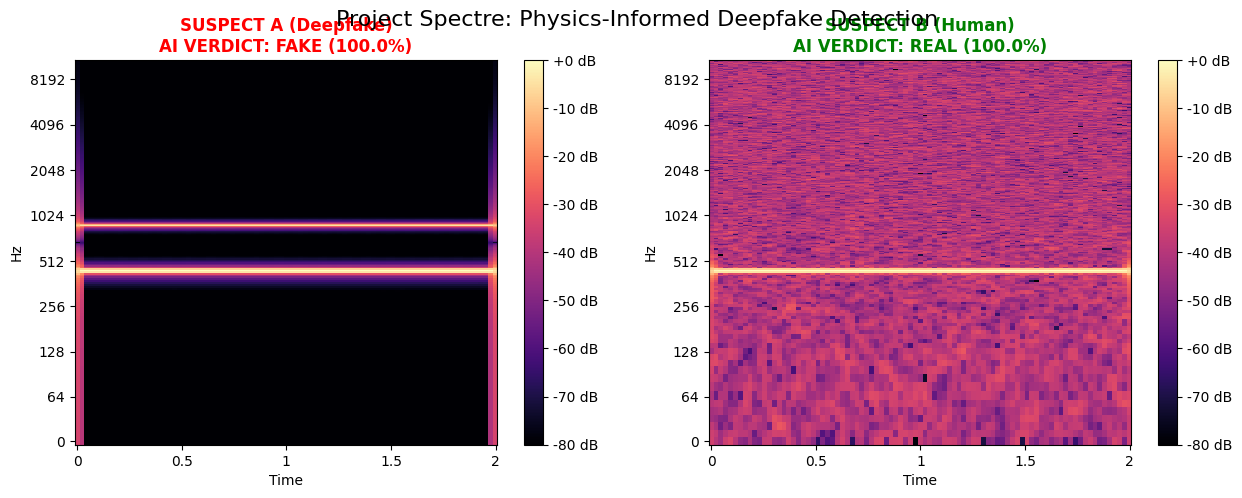

📸 Evidence saved as 'spectre_evidence.png'


In [ ]:
def generate_forensic_report():
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    files = ["dataset/fake/fake_0.wav", "dataset/real/real_0.wav"]
    titles = ["SUSPECT A (Deepfake)", "SUSPECT B (Human)"]

    for i, file_path in enumerate(files):
        # 1. Get Physics
        y, sr = librosa.load(file_path)
        D = librosa.stft(y)
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

        # 2. Plot
        img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=axes[i])

        # 3. Get AI Verdict
        # (Quick re-run of logic)
        melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
        melspec_db = librosa.power_to_db(melspec, ref=np.max)
        melspec_norm = (melspec_db - melspec_db.min()) / (melspec_db.max() - melspec_db.min())
        if melspec_norm.shape[1] > 80: melspec_norm = melspec_norm[:, :80]
        else: melspec_norm = np.pad(melspec_norm, ((0,0), (0, 80 - melspec_norm.shape[1])))

        tensor_in = torch.tensor(melspec_norm).float().unsqueeze(0).unsqueeze(0)
        out = model(tensor_in)
        prob = torch.nn.functional.softmax(out, dim=1)
        fake_score = prob[0][1].item() * 100

        # 4. Stamp Verdict
        color = 'red' if fake_score > 90 else 'green'
        verdict = f"FAKE ({fake_score:.1f}%)" if fake_score > 90 else f"REAL ({100-fake_score:.1f}%)"
        axes[i].set_title(f"{titles[i]}\nAI VERDICT: {verdict}", color=color, fontweight='bold')
        fig.colorbar(img, ax=axes[i], format='%+2.0f dB')

    plt.suptitle("Project Spectre: Physics-Informed Deepfake Detection", fontsize=16)
    plt.savefig("spectre_evidence.png")
    plt.show()
    print("📸 Evidence saved as 'spectre_evidence.png'")

generate_forensic_report()

In [ ]:
# Save the trained weights
torch.save(model.state_dict(), "spectre_v1.pth")
print("💾 Model saved: spectre_v1.pth (Size: ~100KB)")

💾 Model saved: spectre_v1.pth (Size: ~100KB)
